In [81]:
import time
import psutil
import os
from Crypto.Cipher import ChaCha20, AES
from Crypto.Random import get_random_bytes
import pandas as pd
import matplotlib.pyplot as plt

### Encryption Methods

In [82]:
def measure(func):
    """Decorator to measure execution time and memory usage using tracemalloc."""
    def wrapper(*args, **kwargs):
        import tracemalloc
        
        tracemalloc.start()
        start_time = time.perf_counter()
        
        result = func(*args, **kwargs)
        
        end_time = time.perf_counter()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        wrapper.last_metrics = {
            'time_in_ms': (end_time - start_time) * 1000,
            'memory_peak_bytes': peak,  # Maximum memory used during execution
            'memory_final_bytes': current  # Memory still in use at the end
        }
        return result
    wrapper.last_metrics = {}
    return wrapper

@measure
def chacha20_encrypt(message):
    """Encrypt message using ChaCha20."""
    key = get_random_bytes(32)
    nonce = get_random_bytes(12)
    cipher = ChaCha20.new(key=key, nonce=nonce)
    return cipher.encrypt(message)

@measure
def aes_encrypt(message):
    """Encrypt message using AES-256-CBC."""
    key = get_random_bytes(32)
    iv = get_random_bytes(16)
    cipher = AES.new(key, AES.MODE_CBC, iv)
    # Pad message to be multiple of 16 bytes
    pad_length = 16 - (len(message) % 16)
    padded_message = message + bytes([pad_length] * pad_length)
    return cipher.encrypt(padded_message)

### Benchmark

In [83]:
def benchmark_encryption(cipher_name, encrypt_func, message_sizes):
    """Run encryption benchmark for given sizes."""
    results = []
    
    for size in message_sizes:
        # The message is completely random.
        message = get_random_bytes(size)
        
        encrypt_func(message) 
        
        results.append({
            'cipher': cipher_name,
            'message_size': size,
            'time_in_ms': encrypt_func.last_metrics['time_in_ms'],
            'memory_peak_bytes': encrypt_func.last_metrics['memory_peak_bytes'],
            'memory_final_bytes': encrypt_func.last_metrics['memory_final_bytes']
        })
    
    return results

In [84]:
message_sizes = [
        1024,        # 1 KB
        1024 * 5,    # 5 KB
        1024 * 10,   # 10 KB
        1024 * 50,   # 50 KB
        1024 * 100,  # 100 KB
        1024 * 500,  # 500 KB
        1024 * 1000  # 1 MB
    ]
    
results = []
results.extend(benchmark_encryption('ChaCha20', chacha20_encrypt, message_sizes))
results.extend(benchmark_encryption('AES-256', aes_encrypt, message_sizes))

df = pd.DataFrame(results)

df.to_csv('encryption_benchmark_results.csv', index=False)


### Results

In [85]:
print("\nBenchmark Results:")
print("\nAverage encryption time (ms):")
print(df.pivot_table(
    index='message_size', 
    columns='cipher', 
    values='time_in_ms',
    aggfunc='mean'
))

print("\nAverage peak memory usage (MB):")
print(df.pivot_table(
    index='message_size', 
    columns='cipher', 
    values='memory_peak_bytes',
    aggfunc='mean'
) / (1024 * 1024))  

print("\nAverage final memory usage (MB):")
print(df.pivot_table(
    index='message_size', 
    columns='cipher', 
    values='memory_final_bytes',
    aggfunc='mean'
) / (1024 * 1024)) 


Benchmark Results:

Average encryption time (ms):
cipher         AES-256  ChaCha20
message_size                    
1024          0.074375  0.162709
5120          0.072250  0.120541
10240         0.098958  0.144667
51200         0.319750  0.189209
102400        0.606833  0.355083
512000        3.037791  1.616375
1024000       5.359584  3.090916

Average peak memory usage (MB):
cipher         AES-256  ChaCha20
message_size                    
1024          0.002651  0.001708
5120          0.010464  0.005286
10240         0.020229  0.010767
51200         0.098354  0.049232
102400        0.196011  0.098060
512000        0.977261  0.488685
1024000       1.953823  0.976966

Average final memory usage (MB):
cipher         AES-256  ChaCha20
message_size                    
1024          0.001245  0.001336
5120          0.005151  0.004914
10240         0.010034  0.010395
51200         0.049096  0.048860
102400        0.097924  0.097688
512000        0.488549  0.488313
1024000       0.976830  

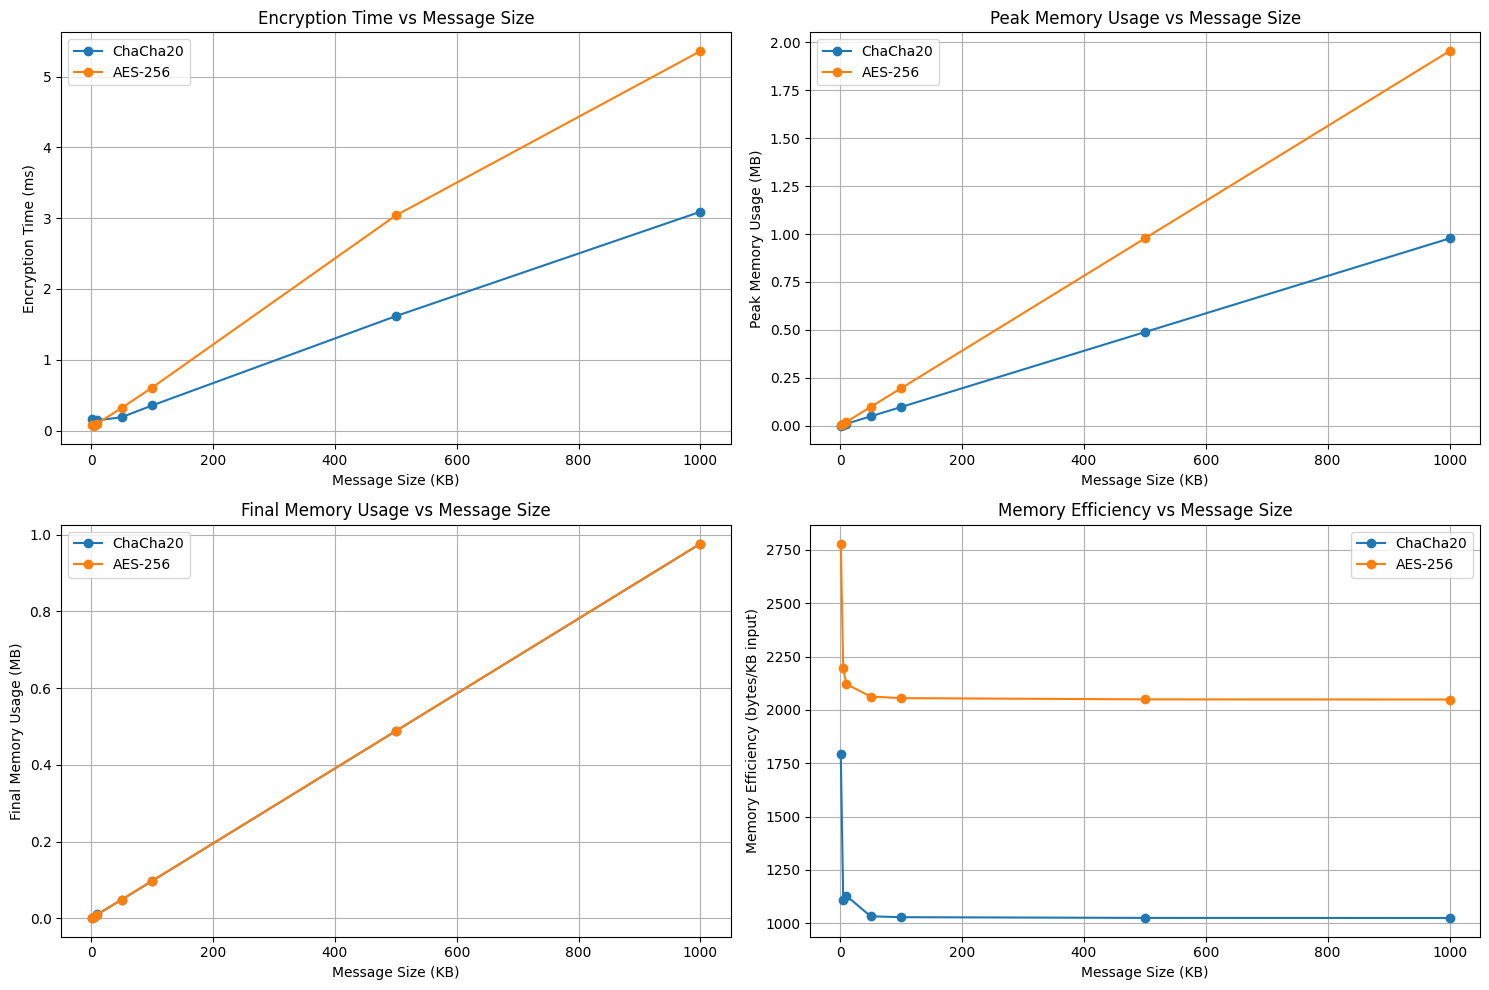

In [86]:
plt.figure(figsize=(15, 10))

# Time plot
plt.subplot(2, 2, 1)
for cipher in df['cipher'].unique():
    cipher_data = df[df['cipher'] == cipher]
    plt.plot(cipher_data['message_size'] / 1024, cipher_data['time_in_ms'], 
            marker='o', label=cipher)
plt.xlabel('Message Size (KB)')
plt.ylabel('Encryption Time (ms)')
plt.title('Encryption Time vs Message Size')
plt.legend()
plt.grid(True)

# Peak memory plot
plt.subplot(2, 2, 2)
for cipher in df['cipher'].unique():
    cipher_data = df[df['cipher'] == cipher]
    # Convert bytes to MB for readability
    plt.plot(cipher_data['message_size'] / 1024, 
             cipher_data['memory_peak_bytes'] / (1024 * 1024), 
             marker='o', label=cipher)
plt.xlabel('Message Size (KB)')
plt.ylabel('Peak Memory Usage (MB)')
plt.title('Peak Memory Usage vs Message Size')
plt.legend()
plt.grid(True)

# Final memory plot
plt.subplot(2, 2, 3)
for cipher in df['cipher'].unique():
    cipher_data = df[df['cipher'] == cipher]
    # Convert bytes to MB for readability
    plt.plot(cipher_data['message_size'] / 1024, 
             cipher_data['memory_final_bytes'] / (1024 * 1024), 
             marker='o', label=cipher)
plt.xlabel('Message Size (KB)')
plt.ylabel('Final Memory Usage (MB)')
plt.title('Final Memory Usage vs Message Size')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for cipher in df['cipher'].unique():
    cipher_data = df[df['cipher'] == cipher]
    efficiency = cipher_data['memory_peak_bytes'] / (cipher_data['message_size'] / 1024)
    plt.plot(cipher_data['message_size'] / 1024, efficiency, 
             marker='o', label=cipher)
plt.xlabel('Message Size (KB)')
plt.ylabel('Memory Efficiency (bytes/KB input)')
plt.title('Memory Efficiency vs Message Size')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### ¿Qué cifrado es mas rápido ChaCha20 o AES?

Según los resultados del benchmark, ChaCha20 es consistentemente más rápido que AES-256 en todos los tamaños de mensaje probados. Por ejemplo, para mensajes de 1MB, ChaCha20 tarda aproximadamente 3ms mientras que AES-256 requiere más de 5ms, lo que hace a ChaCha20 aproximadamente un 40% más rápido. 

Esta ventaja de rendimiento se debe principalmente al diseño algorítmico de ChaCha20, que utiliza operaciones simples como adición, rotación y XOR (ARX) que son muy eficientes en implementaciones de software y no requiere tablas de búsqueda (S-boxes) como AES. Además, ChaCha20 también demuestra un uso de memoria más eficiente, utilizando aproximadamente la mitad de memoria que AES-256 durante el proceso de cifrado, lo que lo hace particularmente adecuado para dispositivos con recursos limitados como móviles o sistemas IoT.

### ¿En qué casos debería usarse en vez de AES?

- Dispositivos con recursos limitados: En sistemas embebidos, IoT o dispositivos móviles donde los recursos computacionales y la memoria son limitados, ChaCha20 ofrece mejor rendimiento con menor consumo de memoria.

- Implementaciones en software puro: Cuando no se dispone de aceleración por hardware para AES (como las instrucciones AES-NI en procesadores modernos), ChaCha20 suele ser significativamente más rápido.

- Conexiones móviles: Para aplicaciones móviles o redes con ancho de banda limitado, como lo demuestra la preferencia de Google por ChaCha20-Poly1305 en conexiones TLS desde dispositivos móviles en Chrome.

- Streaming de datos: Para cifrado de flujos de datos en tiempo real donde la velocidad es crítica.